In [1]:
import matplotlib.pyplot as pl
import numpy as np
import torch
from scipy.spatial.transform import Rotation
import plotly.graph_objects as go
import plotly.subplots as sp
import trimesh
import hydra
from omegaconf import OmegaConf
import os
import time
import copy

import rootutils
rootutils.setup_root("/opt/hpcaas/.mounts/fs-0565f60d669b6a2d3/home/jianingy/research/accel-cortex/dust3r/fast3r/src", indicator=".project-root", pythonpath=True)

from src.models.multiview_dust3r_module import MultiViewDUSt3RLitModule
from src.dust3r.inference_multiview import inference
from src.dust3r.model import FlashDUSt3R
from src.dust3r.utils.image import load_images, rgb
from src.dust3r.viz import CAM_COLORS, OPENGL, add_scene_cam, cat_meshes, pts3d_to_trimesh


pl.ion()


def get_reconstructed_scene(
    outdir,
    model,
    device,
    silent,
    image_size,
    filelist,
    profiling=False,
    dtype=torch.float32,
):
    """
    from a list of images, run dust3r inference, global aligner.
    then run get_3D_model_from_scene
    """
    multiple_views_in_one_sample = load_images(filelist, size=image_size, verbose=not silent)

    # time the inference
    start = time.time()
    output = inference(multiple_views_in_one_sample, model, device, dtype=dtype, verbose=not silent, profiling=profiling)
    end = time.time()
    print(f"Time elapsed: {end - start}")

    return output



def plot_rgb_images(views, title="RGB Images"):
    fig = sp.make_subplots(rows=1, cols=len(views), subplot_titles=[f"View {i} Image" for i in range(len(views))])

    # Plot the RGB images
    for i, view in enumerate(views):
        img_rgb = view['img'].cpu().numpy().squeeze().transpose(1, 2, 0)  # Shape: (224, 224, 3)
        # Rescale RGB values from [-1, 1] to [0, 255]
        img_rgb = ((img_rgb + 1) * 127.5).astype(int).clip(0, 255)
        
        fig.add_trace(go.Image(z=img_rgb), row=1, col=i+1)

    fig.update_layout(
        title=title,
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()

def plot_confidence_maps(preds, title="Confidence Maps"):
    fig = sp.make_subplots(rows=1, cols=len(preds), subplot_titles=[f"View {i} Confidence" for i in range(len(preds))])

    # Plot the confidence maps
    for i, pred in enumerate(preds):
        conf = pred['conf'].cpu().numpy().squeeze()
        fig.add_trace(go.Heatmap(z=conf, colorscale='Viridis', showscale=False), row=1, col=i+1)

    fig.update_layout(
        title=title,
        margin=dict(l=0, r=0, b=0, t=40)
    )

    for i in range(len(preds)):
        fig['layout'][f'yaxis{i+1}'].update(autorange='reversed')

    fig.show()

def maybe_plot_local_depth_and_conf(preds, title="Local Depth and Confidence Maps"):
    # Define the number of columns based on available keys
    num_plots = len(preds)
    rows = 2  # one for confidence maps, one for depth maps
    cols = num_plots

    # Create subplots for both confidence and depth maps
    fig = sp.make_subplots(
        rows=rows, 
        cols=cols, 
        subplot_titles=[f"View {i+1} Conf" if 'conf_local' in pred else f"View {i+1} No Conf" for i, pred in enumerate(preds)]
    )

    # Iterate over preds to add confidence and depth maps if the fields exist
    for i, pred in enumerate(preds):
        # Add confidence map if "conf_local" exists
        if 'conf_local' in pred:
            conf_local = pred['conf_local'].cpu().numpy().squeeze()
            fig.add_trace(go.Heatmap(z=conf_local, colorscale='Viridis', showscale=False), row=1, col=i+1)
        
        # Add depth map if "pts3d_local" exists
        if 'pts3d_local' in pred:
            # Extract Z values as depth from pts3d_local (XY plane)
            depth_local = pred['pts3d_local'][..., 2].cpu().numpy().squeeze()  # Use the Z-coordinate
            fig.add_trace(go.Heatmap(z=depth_local, colorscale='Greys', showscale=False), row=2, col=i+1)

    # Update layout for the figure
    fig.update_layout(
        title=title,
        margin=dict(l=0, r=0, b=0, t=40)
    )

    # Reverse the y-axis for each subplot for consistency
    for i in range(num_plots):
        if 'conf_local' in preds[i]:
            fig['layout'][f'yaxis{i*2+1}'].update(autorange='reversed')
        if 'pts3d_local' in preds[i]:
            fig['layout'][f'yaxis{i*2+2}'].update(autorange='reversed')

    fig.show()

def plot_3d_points_with_colors(preds, views, title="3D Points Visualization", flip_axes=False, as_mesh=False, min_conf_thr_percentile=80, export_ply_path=None):
    fig = go.Figure()

    all_points = []
    all_colors = []
    
    if as_mesh:
        meshes = []
        for i, pred in enumerate(preds):
            pts3d = pred['pts3d_in_other_view'].cpu().numpy().squeeze()  # Ensure tensor is on CPU and convert to numpy
            img_rgb = views[i]['img'].cpu().numpy().squeeze().transpose(1, 2, 0)  # Shape: (224, 224, 3)
            conf = pred['conf'].cpu().numpy().squeeze()

            # Determine the confidence threshold based on the percentile
            conf_thr = np.percentile(conf, min_conf_thr_percentile)

            # Filter points based on the confidence threshold
            mask = conf > conf_thr

            # Rescale RGB values from [-1, 1] to [0, 255]
            img_rgb = ((img_rgb + 1) * 127.5).astype(np.uint8).clip(0, 255)

            # Generate the mesh for the current view
            mesh_dict = pts3d_to_trimesh(img_rgb, pts3d, valid=mask)
            meshes.append(mesh_dict)

        # Concatenate all meshes
        combined_mesh = trimesh.Trimesh(**cat_meshes(meshes))

        # Flip axes if needed
        if flip_axes:
            combined_mesh.vertices[:, [1, 2]] = combined_mesh.vertices[:, [2, 1]]
            combined_mesh.vertices[:, 2] = -combined_mesh.vertices[:, 2]

        # Export as .ply if the path is provided
        if export_ply_path:
            combined_mesh.export(export_ply_path)

        # Add the combined mesh to the plotly figure
        vertex_colors = combined_mesh.visual.vertex_colors[:, :3]  # Ensure the colors are in RGB format
        # Map vertex colors to face colors
        face_colors = []
        for face in combined_mesh.faces:
            face_colors.append(np.mean(vertex_colors[face], axis=0))
        face_colors = np.array(face_colors).astype(int)
        face_colors = ['rgb({}, {}, {})'.format(r, g, b) for r, g, b in face_colors]

        fig.add_trace(go.Mesh3d(
            x=combined_mesh.vertices[:, 0], 
            y=combined_mesh.vertices[:, 1], 
            z=combined_mesh.vertices[:, 2],
            i=combined_mesh.faces[:, 0], 
            j=combined_mesh.faces[:, 1], 
            k=combined_mesh.faces[:, 2],
            facecolor=face_colors,
            opacity=0.5,
            name="Combined Mesh"
        ))
    else:
        # Loop through each set of points in preds
        for i, pred in enumerate(preds):
            pts3d = pred['pts3d_in_other_view'].cpu().numpy().squeeze()  # Ensure tensor is on CPU and convert to numpy
            img_rgb = views[i]['img'].cpu().numpy().squeeze().transpose(1, 2, 0)  # Shape: (224, 224, 3)
            conf = pred['conf'].cpu().numpy().squeeze()

            # Determine the confidence threshold based on the percentile
            conf_thr = np.percentile(conf, min_conf_thr_percentile)

            # Flatten the points and colors
            x, y, z = pts3d[..., 0].flatten(), pts3d[..., 1].flatten(), pts3d[..., 2].flatten()
            r, g, b = img_rgb[..., 0].flatten(), img_rgb[..., 1].flatten(), img_rgb[..., 2].flatten()
            conf_flat = conf.flatten()

            # Apply confidence mask
            mask = conf_flat > conf_thr
            x, y, z = x[mask], y[mask], z[mask]
            r, g, b = r[mask], g[mask], b[mask]

            # Collect points and colors for exporting
            all_points.append(np.vstack([x, y, z]).T)
            all_colors.append(np.vstack([r, g, b]).T)

            # Rescale RGB values from [-1, 1] to [0, 255]
            r = ((r + 1) * 127.5).astype(int).clip(0, 255)
            g = ((g + 1) * 127.5).astype(int).clip(0, 255)
            b = ((b + 1) * 127.5).astype(int).clip(0, 255)

            colors = ['rgb({}, {}, {})'.format(r[j], g[j], b[j]) for j in range(len(r))]
            
            # Check the flag and flip axes if needed
            if flip_axes:
                x, y, z = x, z, y
                z = -z

            # Add points to the plot
            fig.add_trace(go.Scatter3d(
                x=x, y=y, z=z,
                mode='markers',
                marker=dict(size=2, opacity=0.8, color=colors),
                name=f"View {i}"
            ))

        # Export as .ply if the path is provided
        if export_ply_path:
            all_points = np.vstack(all_points)
            all_colors = np.vstack(all_colors)
            point_cloud = trimesh.PointCloud(vertices=all_points, colors=all_colors)
            point_cloud.export(export_ply_path)

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        height=1000
    )

    fig.show()


import numpy as np
import torch
import plotly.graph_objects as go
from src.dust3r.cloud_opt.init_im_poses import fast_pnp
from src.dust3r.viz import auto_cam_size
from src.dust3r.viz_plotly import SceneViz
from src.dust3r.utils.image import rgb  # Assuming you have this utility for image processing


# Function to visualize 3D points and camera poses with SceneViz
def plot_3d_points_with_estimated_camera_poses(preds, views, title="3D Points and Camera Poses", flip_axes=False, min_conf_thr_percentile=80, export_ply_path=None, export_html_path=None):
    # Initialize SceneViz for visualization
    viz = SceneViz()

    # Flip axes if requested
    if flip_axes:
        preds = copy.deepcopy(preds)
        for i, pred in enumerate(preds):
            pts3d = pred['pts3d_in_other_view']
            pts3d = pts3d[..., [0, 2, 1]]  # Swap Y and Z axes
            pts3d[..., 2] *= -1  # Flip the sign of the Z axis
            pred['pts3d_in_other_view'] = pts3d  # Reassign the modified points back to pred

    # Estimate camera poses and focal lengths
    poses_c2w, estimated_focals = MultiViewDUSt3RLitModule.estimate_camera_poses(preds, niter_PnP=10)
    poses_c2w = poses_c2w[0]  # batch size is 1
    estimated_focals = estimated_focals[0]  # batch size is 1
    cam_size = max(auto_cam_size(poses_c2w), 0.05)  # Auto-scale based on the point cloud

    # Set up point clouds and visualization
    for i, (pred, pose_c2w) in enumerate(zip(preds, poses_c2w)):
        pts3d = pred['pts3d_in_other_view'].cpu().numpy().squeeze()  # (224, 224, 3)
        img_rgb = rgb(views[i]['img'].cpu().numpy().squeeze().transpose(1, 2, 0))  # Shape: (224, 224, 3)
        conf = pred['conf'].cpu().numpy().squeeze()

        # Determine the confidence threshold based on the percentile
        conf_thr = np.percentile(conf, min_conf_thr_percentile)
        mask = conf > conf_thr

        # Add the point cloud directly to the SceneViz object
        viz.add_pointcloud(pts3d, img_rgb, mask=mask, point_size=1.0, view_idx=i)

        # Add camera to the visualization
        viz.add_camera(
            pose_c2w=pose_c2w,  # Estimated camera-to-world pose
            focal=estimated_focals[i],  # Estimated focal length for each view
            color=np.random.randint(0, 256, size=3),  # Generate a random RGB color for each camera
            image=img_rgb,  # Image of the view
            cam_size=cam_size,  # Auto-scaled camera size
            view_idx=i
        )

    # Export point clouds and meshes if the path is provided
    if export_ply_path:
        all_points = []
        all_colors = []
        for i, pred in enumerate(preds):
            pts3d = pred['pts3d_in_other_view'].cpu().numpy().squeeze()
            img_rgb = views[i]['img'].cpu().numpy().squeeze().transpose(1, 2, 0)
            conf = pred['conf'].cpu().numpy().squeeze()
            conf_thr = np.percentile(conf, min_conf_thr_percentile)
            mask = conf > conf_thr
            all_points.append(pts3d[mask])
            all_colors.append(img_rgb[mask])
        
        all_points = np.vstack(all_points)
        all_colors = np.vstack(all_colors)
        point_cloud = trimesh.PointCloud(vertices=all_points, colors=all_colors)
        point_cloud.export(export_ply_path)
    
    if export_html_path:
        viz.export_html(export_html_path)

    # Show the visualization
    viz.show()


Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


/data/home/jianingy/miniforge3/envs/dust3r/lib/python3.11/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/data/home/jianingy/miniforge3/envs/dust3r/lib/python3.11/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/data/home/jianingy/miniforge3/envs/dust3r/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/data/home/jianingy/miniforge3/

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


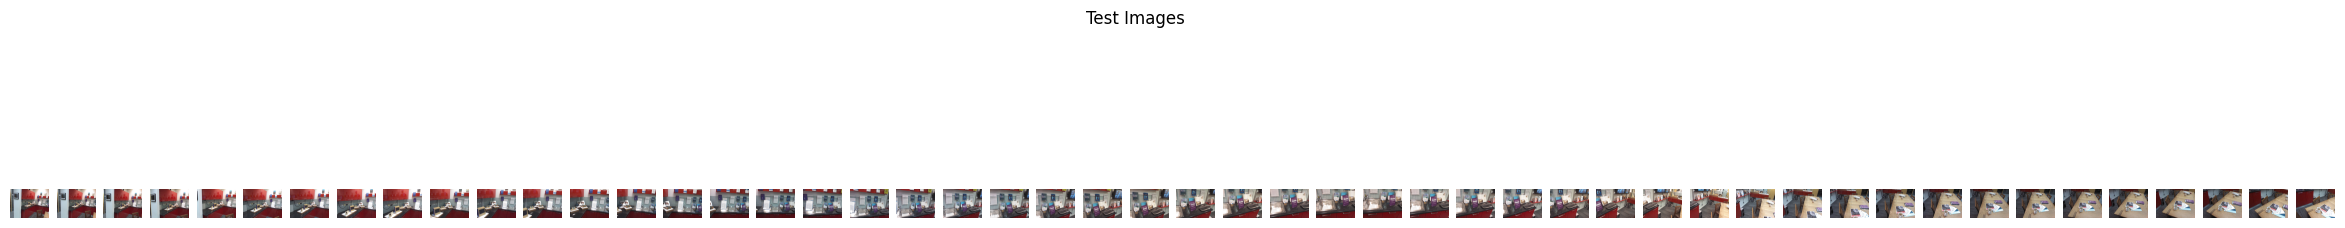

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

data_root = "/opt/hpcaas/.mounts/fs-0565f60d669b6a2d3/home/jianingy/research/accel-cortex/dust3r/data"

filelist_train = [
    f"{data_root}/co3d_subset_processed/apple/189_20393_38136/images/frame000001.jpg",
    f"{data_root}/co3d_subset_processed/apple/189_20393_38136/images/frame000002.jpg"
]

# apple
# filelist_test = [
#     f"{data_root}/co3d_subset_processed/apple/189_20393_38136/images/frame000200.jpg",
#     f"{data_root}/co3d_subset_processed/apple/189_20393_38136/images/frame000085.jpg",
#     f"{data_root}/co3d_subset_processed/apple/189_20393_38136/images/frame000090.jpg",
#     f"{data_root}/co3d_subset_processed/apple/189_20393_38136/images/frame000170.jpg",
#     f"{data_root}/co3d_subset_processed/apple/189_20393_38136/images/frame000199.jpg",
# ]


# bench test
# filelist_test = [
#     f"{data_root}/co3d_subset_processed/bench/415_57112_110099/images/frame000006.jpg",
#     f"{data_root}/co3d_subset_processed/bench/415_57112_110099/images/frame000016.jpg",
#     f"{data_root}/co3d_subset_processed/bench/415_57112_110099/images/frame000026.jpg",
#     f"{data_root}/co3d_subset_processed/bench/415_57112_110099/images/frame000036.jpg",
#     f"{data_root}/co3d_subset_processed/bench/415_57112_110099/images/frame000096.jpg",
#     f"{data_root}/co3d_subset_processed/bench/415_57112_110099/images/frame000126.jpg",
#     f"{data_root}/co3d_subset_processed/bench/415_57112_110099/images/frame000156.jpg",
#     f"{data_root}/co3d_subset_processed/bench/415_57112_110099/images/frame000186.jpg",
# ]

# # teddy bear train
# filelist_test = [
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000001.jpg",
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000002.jpg",
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000003.jpg",
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000004.jpg",
#     # f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000012.jpg",
#     # f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000022.jpg",
#     # f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000032.jpg",
# ]
# teddy bear test
# filelist_test = [
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000006.jpg",
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000016.jpg",
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000026.jpg",
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000036.jpg",
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000096.jpg",
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000126.jpg",
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000156.jpg",
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000186.jpg",
# ]

# teddy bear random order
# filelist_test = [
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000126.jpg",
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000036.jpg",
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000096.jpg",
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000006.jpg",
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000026.jpg",
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000186.jpg",
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000016.jpg",
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000156.jpg",
# ]


# filelist_test = [
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000006.jpg",
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000036.jpg",
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000066.jpg",
#     f"{data_root}/co3d_subset_processed/teddybear/34_1479_4753/images/frame000096.jpg",
# ]

# suitcase test
# filelist_test = [
#     f"{data_root}/co3d_subset_processed/suitcase/50_2928_8645/images/frame000006.jpg",
#     f"{data_root}/co3d_subset_processed/suitcase/50_2928_8645/images/frame000016.jpg",
#     f"{data_root}/co3d_subset_processed/suitcase/50_2928_8645/images/frame000026.jpg",
#     f"{data_root}/co3d_subset_processed/suitcase/50_2928_8645/images/frame000036.jpg",
#     f"{data_root}/co3d_subset_processed/suitcase/50_2928_8645/images/frame000096.jpg",
#     f"{data_root}/co3d_subset_processed/suitcase/50_2928_8645/images/frame000126.jpg",
#     f"{data_root}/co3d_subset_processed/suitcase/50_2928_8645/images/frame000156.jpg",
#     f"{data_root}/co3d_subset_processed/suitcase/50_2928_8645/images/frame000186.jpg",
# ]

# cake test
# filelist_test = [
#     f"{data_root}/co3d_subset_processed/cake/374_42274_84517/images/frame000006.jpg",
#     f"{data_root}/co3d_subset_processed/cake/374_42274_84517/images/frame000016.jpg",
#     f"{data_root}/co3d_subset_processed/cake/374_42274_84517/images/frame000026.jpg",
#     f"{data_root}/co3d_subset_processed/cake/374_42274_84517/images/frame000036.jpg",
#     f"{data_root}/co3d_subset_processed/cake/374_42274_84517/images/frame000096.jpg",
#     f"{data_root}/co3d_subset_processed/cake/374_42274_84517/images/frame000126.jpg",
#     f"{data_root}/co3d_subset_processed/cake/374_42274_84517/images/frame000156.jpg",
#     f"{data_root}/co3d_subset_processed/cake/374_42274_84517/images/frame000186.jpg",
# ]

# in-the-wild obj: book
# filelist_test = [
#     f"{data_root}/unseen_book/IMG_9837.jpg",
#     f"{data_root}/unseen_book/IMG_9838.jpg",
#     f"{data_root}/unseen_book/IMG_9839.jpg",
#     f"{data_root}/unseen_book/IMG_9840.jpg",
#     f"{data_root}/unseen_book/IMG_9841.jpg",
#     f"{data_root}/unseen_book/IMG_9842.jpg",
#     f"{data_root}/unseen_book/IMG_9843.jpg",
#     f"{data_root}/unseen_book/IMG_9844.jpg",
# ]

# in-the-wild obj: beef jerky
# filelist_test = [
#     f"{data_root}/beef_jerky/IMG_0050.jpg",
#     f"{data_root}/beef_jerky/IMG_0051.jpg",
#     f"{data_root}/beef_jerky/IMG_0052.jpg",
#     f"{data_root}/beef_jerky/IMG_0053.jpg",
#     f"{data_root}/beef_jerky/IMG_0054.jpg",
#     f"{data_root}/beef_jerky/IMG_0055.jpg",
#     f"{data_root}/beef_jerky/IMG_0056.jpg",
#     f"{data_root}/beef_jerky/IMG_0057.jpg",
#     f"{data_root}/beef_jerky/IMG_0058.jpg",
# ]


# ArkitScenes
# filelist_test = [
#     f"/datasets01/ARKitScenes/raw/Validation/41069021/vga_wide/41069021_312.125.png",
#     f"/datasets01/ARKitScenes/raw/Validation/41069021/vga_wide/41069021_313.124.png",
#     f"/datasets01/ARKitScenes/raw/Validation/41069021/vga_wide/41069021_314.124.png",
#     f"/datasets01/ARKitScenes/raw/Validation/41069021/vga_wide/41069021_315.123.png",
#     f"/datasets01/ARKitScenes/raw/Validation/41069021/vga_wide/41069021_316.123.png",
#     f"/datasets01/ARKitScenes/raw/Validation/41069021/vga_wide/41069021_317.123.png",
#     f"/datasets01/ARKitScenes/raw/Validation/41069021/vga_wide/41069021_318.122.png",
# ]

# HSSD
# filelist_test = [
#     f"{data_root}/0_102344022_0/rgb/0000{i:02d}.png" for i in range(8)
# ]

# filelist_test = [
#     f"{data_root}/17_102344250_4/rgb/0000{i:02d}.png" for i in range(0,15)
# ]

# unseen obj: teddy bear from co3d
# filelist_test = [
#     "/datasets01/co3dv2/080422/teddybear/595_90395_180050/images/frame000006.jpg",
#     "/datasets01/co3dv2/080422/teddybear/595_90395_180050/images/frame000036.jpg",
#     "/datasets01/co3dv2/080422/teddybear/595_90395_180050/images/frame000056.jpg",
#     "/datasets01/co3dv2/080422/teddybear/595_90395_180050/images/frame000086.jpg",
#     "/datasets01/co3dv2/080422/teddybear/595_90395_180050/images/frame000096.jpg",
#     "/datasets01/co3dv2/080422/teddybear/595_90395_180050/images/frame000126.jpg",
#     "/datasets01/co3dv2/080422/teddybear/595_90395_180050/images/frame000156.jpg",
#     "/datasets01/co3dv2/080422/teddybear/595_90395_180050/images/frame000186.jpg",
# ]


# unseen obj: keyboard from co3d
# filelist_test = [
#     "/datasets01/co3dv2/080422/keyboard/604_93822_187288/images/frame000096.jpg",
#     "/datasets01/co3dv2/080422/keyboard/604_93822_187288/images/frame000126.jpg",
#     "/datasets01/co3dv2/080422/keyboard/604_93822_187288/images/frame000156.jpg",
#     # "/datasets01/co3dv2/080422/keyboard/604_93822_187288/images/frame000186.jpg",
#     # "/datasets01/co3dv2/080422/keyboard/604_93822_187288/images/frame000006.jpg",
#     # "/datasets01/co3dv2/080422/keyboard/604_93822_187288/images/frame000016.jpg",
#     # "/datasets01/co3dv2/080422/keyboard/604_93822_187288/images/frame000026.jpg",
#     "/datasets01/co3dv2/080422/keyboard/604_93822_187288/images/frame000036.jpg",
# ]

# filelist_test = [
#     "/fsx-cortex/jianingy/dust3r_data/co3d_50_seqs_per_category_subset_processed/keyboard/76_7733_16196/images/frame000006.jpg",
#     "/fsx-cortex/jianingy/dust3r_data/co3d_50_seqs_per_category_subset_processed/keyboard/76_7733_16196/images/frame000016.jpg",
#     "/fsx-cortex/jianingy/dust3r_data/co3d_50_seqs_per_category_subset_processed/keyboard/76_7733_16196/images/frame000026.jpg",
#     "/fsx-cortex/jianingy/dust3r_data/co3d_50_seqs_per_category_subset_processed/keyboard/76_7733_16196/images/frame000036.jpg",
#     "/fsx-cortex/jianingy/dust3r_data/co3d_50_seqs_per_category_subset_processed/keyboard/76_7733_16196/images/frame000096.jpg",
#     "/fsx-cortex/jianingy/dust3r_data/co3d_50_seqs_per_category_subset_processed/keyboard/76_7733_16196/images/frame000126.jpg",
#     "/fsx-cortex/jianingy/dust3r_data/co3d_50_seqs_per_category_subset_processed/keyboard/76_7733_16196/images/frame000156.jpg",
#     "/fsx-cortex/jianingy/dust3r_data/co3d_50_seqs_per_category_subset_processed/keyboard/76_7733_16196/images/frame000186.jpg",
# ]

# DTU
# filelist_test = [
#     "/fsx-cortex/jianingy/dust3r_data/datasets_raw/DTU/SampleSet/MVS Data/Rectified/scan6/rect_001_max.png",
#     "/fsx-cortex/jianingy/dust3r_data/datasets_raw/DTU/SampleSet/MVS Data/Rectified/scan6/rect_002_max.png",
#     "/fsx-cortex/jianingy/dust3r_data/datasets_raw/DTU/SampleSet/MVS Data/Rectified/scan6/rect_003_max.png",
#     "/fsx-cortex/jianingy/dust3r_data/datasets_raw/DTU/SampleSet/MVS Data/Rectified/scan6/rect_004_max.png",
#     "/fsx-cortex/jianingy/dust3r_data/datasets_raw/DTU/SampleSet/MVS Data/Rectified/scan6/rect_005_max.png",
#     "/fsx-cortex/jianingy/dust3r_data/datasets_raw/DTU/SampleSet/MVS Data/Rectified/scan6/rect_006_max.png",
#     "/fsx-cortex/jianingy/dust3r_data/datasets_raw/DTU/SampleSet/MVS Data/Rectified/scan6/rect_007_max.png",
#     "/fsx-cortex/jianingy/dust3r_data/datasets_raw/DTU/SampleSet/MVS Data/Rectified/scan6/rect_008_max.png",
# ]


# DTU test
# filelist_test = [f"/fsx-cortex/jianingy/dust3r_data/dtu_test_mvsnet_release/scan4/images/000000{i:02d}.jpg" for i in range(0, 49, 1)]

# NRGBD test
# filelist_test = [f"/fsx-cortex/jianingy/dust3r_data/neural_rgbd/kitchen/images/img{i}.png" for i in range(1, 1517, 30)]  #[:30]

# 7-Scenes test
# filelist_test = [f"/fsx-cortex/jianingy/dust3r_data/7_scenes_processed/redkitchen/seq-06/frame-00{i:04d}.color.png" for i in range(0, 1000, 10)]
filelist_test = [f"/fsx-cortex/jianingy/dust3r_data/7_scenes_processed/redkitchen/seq-03/frame-00{i:04d}.color.png" for i in range(0, 1000, 20)]

# # reverse the order
# filelist_test = filelist_test[::-1]

# display the images
def display_images(filelist, title):
    fig, axes = plt.subplots(1, len(filelist), figsize=(30, 4))
    fig.suptitle(title)
    for ax, filepath in zip(axes if hasattr(axes, '__iter__') else [axes], filelist):
        img = Image.open(filepath)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# # Display train images
# display_images(filelist_train, 'Train Images')

# Display test images
display_images(filelist_test, 'Test Images')

In [ ]:
device = torch.device("cuda")

checkpoint_root = "/opt/hpcaas/.mounts/fs-0565f60d669b6a2d3/home/jianingy/research/accel-cortex/dust3r/checkpoints"

# model = FlashDUSt3R.from_pretrained(f'{checkpoint_root}/dust3r_demo_224_longer_epochs/checkpoint-best.pth').to(device)
# model = FlashDUSt3R.from_pretrained(f'{checkpoint_root}/dust3r_demo_224_multiview/checkpoint-best.pth').to(device)
# model = FlashDUSt3R.from_pretrained(f'{checkpoint_root}/dust3r_demo_224_multiview_co3d_full/checkpoint-last.pth').to(device)
# model = FlashDUSt3R.from_pretrained(f'{checkpoint_root}/dust3r_demo_224_multiview_co3d_full_100_epochs_100_samples_per_window/checkpoint-last.pth').to(device)
# model = FlashDUSt3R.from_pretrained(f'{checkpoint_root}/dust3r_512_dpt_finetune_multiview_co3d_50_seqs_per_cat_subset/checkpoint-best.pth').to(device)
# model = FlashDUSt3R.from_pretrained(f'{checkpoint_root}/dust3r_512_dpt_finetune_multiview_co3d_50_seqs_per_cat_subset_100_epochs_unfreeze_dec_and_head/checkpoint-last.pth').to(device)
# model = FlashDUSt3R.from_pretrained(f'{checkpoint_root}/dust3r_512_dpt_finetune_multiview_co3d_50_seqs_per_cat_subset_100_epochs_unfreeze_everything/checkpoint-last.pth').to(device)
# model = FlashDUSt3R.from_pretrained(f'{checkpoint_root}/dust3r_512_dpt_finetune_multiview_co3d_50_seqs_per_cat_subset_100_epochs_unfreeze_everything_large/checkpoint-last.pth').to(device)
# model = FlashDUSt3R.from_pretrained(f'{checkpoint_root}/dust3r_512_dpt_finetune_multiview_co3d_50_seqs_per_cat_subset_100_epochs_unfreeze_everything_co3d_scannetpp_megadepth/checkpoint-last.pth').to(device)
model = FlashDUSt3R.from_pretrained(f'{checkpoint_root}/dust3r_512_dpt_finetune_multiview_co3d_50_seqs_per_cat_subset_100_epochs_unfreeze_everything_co3d_scannetpp_megadepth_large/checkpoint-last.pth').to(device)
# model = FlashDUSt3R.from_pretrained(f'{checkpoint_root}/dust3r_512_dpt_finetune_multiview_co3d_50_seqs_per_cat_subset_100_epochs_unfreeze_everything_co3d_scannetpp_megadepth_large/checkpoint-last.pth').to(device)
# model = FlashDUSt3R.from_pretrained(f'{checkpoint_root}/bf16_flash_attn_unfreeze_everything_co3d_scannetpp_megadepth_large_bs4/checkpoint-10.pth').to(device)
# model = FlashDUSt3R.from_pretrained(f'{checkpoint_root}/bf16_flash_attn_unfreeze_everything_co3d_scannetpp_megadepth_large/checkpoint-last.pth').to(device)

In [3]:
# Lightning model
%load_ext autoreload
%autoreload 2

# instantiate lit module from hydra yaml /opt/hpcaas/.mounts/fs-0565f60d669b6a2d3/home/jianingy/research/accel-cortex/dust3r/fast3r/configs/model/multiview_dust3r.yaml
device = torch.device("cuda:4")
checkpoint_root = "/opt/hpcaas/.mounts/fs-0565f60d669b6a2d3/home/jianingy/research/accel-cortex"

# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/train/runs/2024-08-13_04-40-37"  #fp32-fancy-sun-181
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/train/runs/2024-08-13_08-06-08"  #fp32_workers11_giddy-gorge-182
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/fp32_bs6_views4/runs/fp32_bs6_views4_3782640"
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/fp32_bs2_views8/runs/fp32_bs2_views8_3782638"
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/fp32_bs6_views4/runs/fp32_bs6_views4_4007485"  # with random image idx embeddings
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/fp32_bs6_views4/runs/fp32_bs6_views4_4030983"  # fix Regr3D loss (wrong rotation)
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/fp32_bs6_views4/runs/fp32_bs6_views4_4037511"  # fix Regr3D loss (fixed rotation)
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/fp32_bs6_views4_scannetpp_only/runs/fp32_bs6_views4_scannetpp_only_4060428"  # ScanNet++ only no random emb
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/fp32_bs6_views4_scannetpp_only/runs/fp32_bs6_views4_scannetpp_only_4051504"  # ScanNet++ only
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/fp32_bs6_views4_arkitscenes_only/runs/arkitscenes_only_4123064"  # ARKitScenes only
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/arkitscenes_only_no_pairs/runs/arkitscenes_only_no_pairs_4129400"  # ARKitScenes only no pairs
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/co3d_scannetpp/runs/co3d_scannetpp_4123062"  # co3d_scannetpp
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/co3d_scannetpp_arkitscenes/runs/co3d_scannetpp_arkitscenes_4123063"  # co3d_scannetpp_arkitscenes
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/co3d_scannetpp_arkitscenes_bs2_views8/runs/co3d_scannetpp_arkitscenes_bs2_views8_4155008"  # co3d_scannetpp_arkitscenes 8 views
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/co3d_scannetpp_arkitscenes_better_random_pose_emb/runs/co3d_scannetpp_arkitscenes_better_random_pose_emb_4323524"  # co3d_scannetpp_arkitscenes 8 views

# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/fast3r_co3d_scannetpp_arkitscenes_better_random_pose_emb/runs/fast3r_co3d_scannetpp_arkitscenes_better_random_pose_emb_4365927"
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/fast3r_habitat_larger_decoder_views4/runs/fast3r_habitat_larger_decoder_views4_4383740"
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/fast3r_habitat_larger_decoder_views8/runs/fast3r_habitat_larger_decoder_views8_4383741"
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/fast3r_larger_decoder_bs1_views4/runs/fast3r_larger_decoder_4371625"
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/fast3r_habitat_co3d_scannetpp_arkitscenes/runs/fast3r_habitat_co3d_scannetpp_arkitscenes_4383742"

# local head
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/fast3r_no_local_head/runs/fast3r_no_local_head_4611636"
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/fast3r_no_local_head_habitat/runs/fast3r_no_local_head_habitat_4615832"
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/fast3r_local_head/runs/fast3r_local_head_4638120"
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/fast3r_local_head_habitat/runs/fast3r_local_head_habitat_4626119"

# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/fast3r_local_head_habitat_better_scannetpp/runs/fast3r_local_head_habitat_better_scannetpp_4701731"
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/fast3r_local_head_habitat_better_scannetpp_8views/runs/fast3r_local_head_habitat_better_scannetpp_8views_4726417"
# checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/fast3r_local_head_better_scannetpp_and_arkit_pretrained_16views/runs/fast3r_local_head_better_scannetpp_and_arkit_pretrained_16views_4793676"
checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/fast3r_local_head_better_scannetpp_and_arkit_pretrained_20views_small_lr/runs/fast3r_local_head_better_scannetpp_and_arkit_pretrained_20views_small_lr_4798434"
checkpoint_dir = f"{checkpoint_root}/dust3r/fast3r/logs/fast3r_local_head_better_scannetpp_and_arkit_pretrained_20views_small_lr/runs/fast3r_local_head_better_scannetpp_and_arkit_pretrained_20views_small_lr_4804512"

print("Creating an empty lightning module to hold the weights...")
cfg = OmegaConf.load(os.path.join(checkpoint_dir, '.hydra/config.yaml'))

# replace all occurances of "dust3r." in cfg.model.net with "src.dust3r." (this is due to relocation of our code)
def replace_dust3r_in_config(cfg):
    for key, value in cfg.items():
        if isinstance(value, dict):
            replace_dust3r_in_config(value)
        elif isinstance(value, str):
            if "dust3r." in value and "src.dust3r." not in value:
                cfg[key] = value.replace("dust3r.", "src.dust3r.")
    return cfg


cfg.model.net = replace_dust3r_in_config(cfg.model.net)

if "encoder_args" in cfg.model.net:
    cfg.model.net.encoder_args.patch_embed_cls = "PatchEmbedDust3R"
    cfg.model.net.head_args.landscape_only = False
else:
    cfg.model.net.patch_embed_cls = "PatchEmbedDust3R"  # TODO: investigate what exactly this does, this seems to support inferencing images of protrait orientation
    cfg.model.net.landscape_only = False  # TODO: investigate what exactly this does


lit_module = hydra.utils.instantiate(cfg.model, train_criterion=None, validation_criterion=None)


print("Loading weights from checkpoint...")
CKPT_PATH = os.path.join(checkpoint_dir, 'checkpoints/last.ckpt')

checkpoint = torch.load(CKPT_PATH)
lit_module.on_load_checkpoint(checkpoint)  # fill in the missing parts of the model due to legacy checkpoints
lit_module.load_state_dict(checkpoint["state_dict"])
model = lit_module.net.to(device)
model.eval()

# model = torch.compile(model)

Creating an empty lightning module to hold the weights...
Loading weights from checkpoint...


/tmp/ipykernel_1670231/3194058958.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CKPT_PATH)


Fast3R(
  (encoder): CroCoEncoder(
    (patch_embed): PatchEmbedDust3R(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (rope): RoPE2D()
    (enc_blocks): ModuleList(
      (0-23): 24 x Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
          (rope): RoPE2D()
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
     

In [4]:
model.set_max_parallel_views_for_head(100) # set the maximum number of parallel views for the head

output = get_reconstructed_scene(
    outdir = "./output",
    model = model,
    device = device,
    silent = False,
    # image_size = 224,
    image_size = 512,
    filelist = filelist_test,
    profiling=True,
    dtype = torch.float32,
    # dtype = torch.bfloat16,
)

# local to global alignment
lit_module.align_local_pts3d_to_global(preds=output['preds'], views=output['views'], min_conf_thr_percentile=0)

>> Loading a list of 50 images
 - adding /fsx-cortex/jianingy/dust3r_data/7_scenes_processed/redkitchen/seq-03/frame-000000.color.png with resolution 640x480 --> 512x384
 - adding /fsx-cortex/jianingy/dust3r_data/7_scenes_processed/redkitchen/seq-03/frame-000020.color.png with resolution 640x480 --> 512x384
 - adding /fsx-cortex/jianingy/dust3r_data/7_scenes_processed/redkitchen/seq-03/frame-000040.color.png with resolution 640x480 --> 512x384
 - adding /fsx-cortex/jianingy/dust3r_data/7_scenes_processed/redkitchen/seq-03/frame-000060.color.png with resolution 640x480 --> 512x384
 - adding /fsx-cortex/jianingy/dust3r_data/7_scenes_processed/redkitchen/seq-03/frame-000080.color.png with resolution 640x480 --> 512x384
 - adding /fsx-cortex/jianingy/dust3r_data/7_scenes_processed/redkitchen/seq-03/frame-000100.color.png with resolution 640x480 --> 512x384
 - adding /fsx-cortex/jianingy/dust3r_data/7_scenes_processed/redkitchen/seq-03/frame-000120.color.png with resolution 640x480 --> 512x

In [ ]:
# %load_ext autoreload
# %autoreload 2


# Usage example in your context
# Plot the RGB images
plot_rgb_images(output['views'])

# Plot the confidence maps
plot_confidence_maps(output['preds'])

# Plot the local depth and confidence maps
maybe_plot_local_depth_and_conf(output['preds'])

# Plot the 3D points along with estimated camera poses
plot_3d_points_with_estimated_camera_poses(
    output['preds'],  # Predictions containing 3D points
    output['views'],  # Views containing RGB images
    flip_axes=True,   # Enable flipping of axes (swap Y and Z and flip Z)
    min_conf_thr_percentile=0,  # Confidence threshold percentile for filtering points
    # export_ply_path='./output/combined_mesh.ply'  # Export path for the .ply file
    export_html_path='./output/combined_mesh.html'  # Export path for the .html file
)


In [6]:
server.stop()

(viser) Disconnected from share URL

(viser) Connection closed (0, 0 total)

In [ ]:
def start_visualization(output, pts3d_key_to_visualize, conf_key_to_visualize, min_conf_thr_percentile=50, port=8020):
    import time
    import threading
    import numpy as np
    from tqdm.auto import tqdm
    import imageio.v3 as iio

    import viser
    import viser.transforms as tf
    from src.dust3r.utils.device import to_numpy

    # Create the viser server on the specified port
    server = viser.ViserServer(host='127.0.0.1', port=port)

    # Estimate camera poses
    poses_c2w_batch, estimated_focals = MultiViewDUSt3RLitModule.estimate_camera_poses(
        output['preds'], niter_PnP=10
    )
    poses_c2w = poses_c2w_batch[0]  # Assuming batch size of 1

    # Set the upward direction to negative Y-axis
    server.scene.set_up_direction((0.0, -1.0, 0.0))
    server.scene.world_axes.visible = False  # Optional: Show world axes

    num_frames = len(output['preds'])

    # Process all frames to compute cumulative point cloud dimensions
    cumulative_pts = []

    for i in range(num_frames):
        pred = output['preds'][i]
        # Extract point cloud data
        pts3d = to_numpy(pred[pts3d_key_to_visualize].cpu().squeeze())
        conf = to_numpy(pred[conf_key_to_visualize].cpu().squeeze())

        # Flatten and reshape data
        pts3d = pts3d.reshape(-1, 3)
        conf = conf.flatten()

        # Apply confidence mask
        mask = conf > 0  # Adjust threshold if needed
        pts3d_masked = pts3d[mask]

        # Accumulate points
        cumulative_pts.append(pts3d_masked)

    # Concatenate cumulative points
    cumulative_pts_combined = np.concatenate(cumulative_pts, axis=0)

    # Compute min and max coords
    min_coords = np.min(cumulative_pts_combined, axis=0)
    max_coords = np.max(cumulative_pts_combined, axis=0)

    # Compute scene extent
    scene_extent = max_coords - min_coords
    max_extent = np.max(scene_extent)

    # Initialize frustum size percent
    frustum_size_percent = 2.0  # Default value 2%

    # Prepare to collect frame, point cloud, and frustum nodes
    frame_nodes = []
    point_nodes = []
    frustum_nodes = []

    # Generate colors for frustums in rainbow order
    def rainbow_color(n, total):
        """Generate a color in RGB between red and violet."""
        import colorsys
        hue = n / total  # Hue value between 0 and 1
        rgb = colorsys.hsv_to_rgb(hue, 1.0, 1.0)
        return rgb

    # Add playback UI
    with server.gui.add_folder("Playback"):
        gui_point_size = server.gui.add_slider(
            "Point size",
            min=0.0001,
            max=0.02,
            step=1e-4,
            initial_value=0.002,  # Initial point size set to 0.002
        )
        # Add a slider to allow user to change the frustum size
        gui_frustum_size_percent = server.gui.add_slider(
            "Camera Size (%)",
            min=0.1,
            max=10.0,
            step=0.1,
            initial_value=2.0,  # Default value 2%
        )
        gui_timestep = server.gui.add_slider(
            "Timestep",
            min=0,
            max=num_frames - 1,
            step=1,
            initial_value=0,
            disabled=True,
        )
        gui_next_frame = server.gui.add_button("Next Frame", disabled=True)
        gui_prev_frame = server.gui.add_button("Prev Frame", disabled=True)
        gui_playing = server.gui.add_checkbox("Playing", True)
        gui_framerate = server.gui.add_slider(
            "FPS", min=0, max=60, step=0.25, initial_value=5  # Default FPS set to 0.25
        )
        gui_framerate_options = server.gui.add_button_group(
            "FPS options", ("0.25", "0.5", "1", "2", "5", "10", "20", "30", "60")
        )

    # Add a button to render a GIF
    button_render_gif = server.gui.add_button("Render a GIF")

    # Frame step buttons
    @gui_next_frame.on_click
    def _(_) -> None:
        gui_timestep.value = (gui_timestep.value + 1) % num_frames

    @gui_prev_frame.on_click
    def _(_) -> None:
        gui_timestep.value = (gui_timestep.value - 1) % num_frames

    # Disable frame controls when we're playing
    @gui_playing.on_update
    def _(_) -> None:
        gui_timestep.disabled = gui_playing.value
        gui_next_frame.disabled = gui_playing.value
        gui_prev_frame.disabled = gui_playing.value

    # Set the framerate when we click one of the options
    @gui_framerate_options.on_click
    def _(_) -> None:
        gui_framerate.value = float(gui_framerate_options.value)

    # Load in frames
    server.scene.add_frame("/cams", show_axes=False)

    for i in tqdm(range(num_frames)):
        # Process your data
        pred = output['preds'][i]
        view = output['views'][i]

        # Extract point cloud and image data
        pts3d = to_numpy(pred[pts3d_key_to_visualize].cpu().squeeze())
        conf = to_numpy(pred[conf_key_to_visualize].cpu().squeeze())
        img_rgb = to_numpy(view['img'].cpu().squeeze().permute(1, 2, 0))

        # Flatten and reshape data
        pts3d = pts3d.reshape(-1, 3)
        img_rgb = img_rgb.reshape(-1, 3)
        conf = conf.flatten()

        # Apply confidence mask
        conf_threshold = np.quantile(conf, min_conf_thr_percentile / 100.0)
        # Create the confidence mask based on the computed threshold
        mask = conf >= conf_threshold

        pts3d_masked = pts3d[mask]
        colors_masked = ((img_rgb[mask] + 1) * 127.5).astype(np.uint8) / 255.0  # Normalize colors to [0, 1]

        # Add base frame for the camera
        frame_node = server.scene.add_frame(f"/cams/t{i}", show_axes=False)
        frame_nodes.append(frame_node)

        # Create point cloud node for this frame
        point_node = server.scene.add_point_cloud(
            name=f"/pts3d/t{i}",
            points=pts3d_masked,
            colors=colors_masked,
            point_size=gui_point_size.value,
            point_shape="rounded",
        )
        point_nodes.append(point_node)

        # Compute frustum scale
        frustum_scale = max_extent * (frustum_size_percent / 100.0)

        # Get the camera pose for this frame
        c2w = poses_c2w[i]

        rotation_matrix = c2w[:3, :3]
        position = c2w[:3, 3]

        # Convert rotation matrix to quaternion
        rotation_quaternion = tf.SO3.from_matrix(rotation_matrix).wxyz

        # Get image dimensions
        height, width = view['img'].shape[2], view['img'].shape[3]

        # Use estimated focal length
        focal_length = estimated_focals[0][i]

        # Compute field of view
        fov = 2 * np.arctan2(height / 2, focal_length)
        aspect_ratio = width / height

        # Reshape and normalize the RGB image for the frustum
        img_rgb_reshaped = img_rgb.reshape(height, width, 3)
        img_rgb_normalized = ((img_rgb_reshaped + 1) * 127.5).astype(np.uint8) / 255.0  # Normalize to [0,1]

        # Downsample the RGB image for the frustum
        downsample_factor = 4  # Adjust as needed
        img_downsampled = img_rgb_normalized[::downsample_factor, ::downsample_factor]

        # Generate a color for the frustum in rainbow order
        frustum_color = rainbow_color(i, num_frames)

        # Add the camera frustum with the RGB image and colored outline
        frustum_node = server.scene.add_camera_frustum(
            name=f"/cams/t{i}/frustum",
            fov=fov,
            aspect=aspect_ratio,
            scale=frustum_scale,
            color=frustum_color,
            image=img_downsampled,
            wxyz=rotation_quaternion,
            position=position,
        )
        frustum_nodes.append(frustum_node)

        # Sleep briefly to allow visualization to update
        time.sleep(0.1)

    # Initially set visibility of all frames and point clouds to False
    for frame_node in frame_nodes:
        frame_node.visible = False
    for point_node in point_nodes:
        point_node.visible = False
    for frustum_node in frustum_nodes:
        frustum_node.visible = False

    # Toggle frame visibility when the timestep slider changes
    @gui_timestep.on_update
    def _(_) -> None:
        current_timestep = int(gui_timestep.value)
        with server.atomic():
            # Update point size and visibility
            for i in range(num_frames):
                if i <= current_timestep:
                    point_nodes[i].point_size = gui_point_size.value
                    point_nodes[i].visible = True
                    frame_nodes[i].visible = True
                    frustum_nodes[i].visible = True
                else:
                    point_nodes[i].visible = False
                    frame_nodes[i].visible = False
                    frustum_nodes[i].visible = False
        server.flush()  # Optional

    # Update point size when the point size slider changes
    @gui_point_size.on_update
    def _(_) -> None:
        with server.atomic():
            # Update the point size of each point cloud node
            for point_node in point_nodes:
                point_node.point_size = gui_point_size.value
        server.flush()

    # Update frustum sizes when the frustum size slider changes
    @gui_frustum_size_percent.on_update
    def _(_) -> None:
        frustum_size_percent = gui_frustum_size_percent.value
        new_frustum_scale = max_extent * (frustum_size_percent / 100.0)
        with server.atomic():
            # Update the scale of each frustum node
            for frustum_node in frustum_nodes:
                frustum_node.scale = new_frustum_scale
        server.flush()

    # Playback update loop
    def playback_loop():
        while True:
            if gui_playing.value:
                gui_timestep.value = (int(gui_timestep.value) + 1) % num_frames
            time.sleep(1.0 / gui_framerate.value)

    # Start the playback loop in a separate thread
    playback_thread = threading.Thread(target=playback_loop)
    playback_thread.start()

    # Add functionality to render a GIF
    @button_render_gif.on_click
    def _(event: viser.GuiEvent) -> None:
        client = event.client
        if client is None:
            print("Error: No client connected.")
            return

        try:
            images = []
            num_frames_to_render = num_frames

            # Save the current state
            original_timestep = gui_timestep.value
            original_playing = gui_playing.value

            # Pause playback during rendering
            gui_playing.value = False

            # Get the current frame rate from the client
            fps = gui_framerate.value

            # Set up for rendering
            for i in range(num_frames_to_render):
                gui_timestep.value = i
                time.sleep(0.1)  # Allow time for the scene to update
                image = client.get_render(height=1080, width=1920)  # Specified resolution
                images.append(image)
                print(f"Captured frame {i+1}/{num_frames_to_render}")

            # Generate and send GIF
            print(f"Generating and sending GIF at {fps} FPS...")
            gif_bytes = iio.imwrite("<bytes>", images, extension=".gif", fps=fps, loop=0)
            client.send_file_download("visualization.gif", gif_bytes)
            print("GIF generation complete!")

            # Restore the original state
            gui_timestep.value = original_timestep
            gui_playing.value = original_playing

        except Exception as e:
            print(f"Error while rendering GIF: {e}")

    print(f"Visualization setup complete. Access the viser server at http://localhost:{port}")

    # Create a public URL
    public_url = server.request_share_url()
    print(f"Public URL: {public_url}")

    return server


# server = start_visualization(
#     output=output,
#     pts3d_key_to_visualize="pts3d_in_other_view",
#     conf_key_to_visualize="conf",
#     min_conf_thr_percentile=0,
#     port=8020
# )

server = start_visualization(
    output=output,
    pts3d_key_to_visualize="pts3d_local_aligned_to_global",
    conf_key_to_visualize="conf_local",
    min_conf_thr_percentile=5,
    port=8020
)


╭──────────────── viser ────────────────╮
│             ╷                         │
│   HTTP      │ http://127.0.0.1:8020   │
│   Websocket │ ws://127.0.0.1:8020     │
│             ╵                         │
╰───────────────────────────────────────╯

  0%|          | 0/50 [00:00<?, ?it/s]

Visualization setup complete. Access the viser server at http://localhost:8020


(viser) Share URL requested!

(viser) Generated share URL (expires in 24 hours, max 32 clients): https://descript-scale.share.viser.studio

Public URL: https://descript-scale.share.viser.studio


(viser) Connection opened (0, 1 total), 420 persistent messages

In [ ]:
server.stop()

In [13]:
# save the images to jpgs
for i, img in enumerate(output['views']):
    img = img['img'][0]
    img = img.permute(1, 2, 0).cpu().numpy()
    img = ((img + 1) * 127.5).astype(np.uint8)
    img = Image.fromarray(img)
    img.save(f"./output/img_{i}.jpg")

In [ ]:
import os
import numpy as np
from PIL import Image
from src.dust3r.utils.device import to_numpy
import pyrender

# Set the EGL platform for offscreen rendering
os.environ["PYOPENGL_PLATFORM"] = "egl"

def create_camera_pose(camera_position, target_point, up_vector):
    """
    Create a camera pose matrix (camera-to-world) that positions the camera at camera_position
    and orients it to look at target_point.
    """
    # Compute forward vector (from camera to target)
    forward_vector = target_point - camera_position
    forward_vector /= np.linalg.norm(forward_vector)

    # Compute right and up vectors
    right_vector = np.cross(up_vector, forward_vector)
    if np.linalg.norm(right_vector) < 1e-6:
        # Adjust up_vector if it's parallel to forward_vector
        up_vector = np.array([0, 0, 1]) if up_vector[1] != 1 else np.array([1, 0, 0])
        right_vector = np.cross(up_vector, forward_vector)
    right_vector /= np.linalg.norm(right_vector)
    up_vector = np.cross(forward_vector, right_vector)

    # Construct the camera-to-world matrix
    camera_pose = np.eye(4)
    camera_pose[:3, 0] = right_vector
    camera_pose[:3, 1] = up_vector
    camera_pose[:3, 2] = forward_vector
    camera_pose[:3, 3] = camera_position
    return camera_pose

def convert_c2w_to_opengl_view(c2w):
    """
    Convert a camera-to-world (c2w) extrinsic matrix to an OpenGL-compatible view matrix.
    """
    # Invert the camera-to-world matrix to get world-to-camera (view) matrix
    world_to_camera = np.linalg.inv(c2w)

    # OpenGL requires flipping the Y and Z axes
    opengl_to_camera = np.array([
        [1,  0,  0, 0],
        [0, -1,  0, 0],
        [0,  0, -1, 0],
        [0,  0,  0, 1]
    ])

    # Compute the OpenGL view matrix
    opengl_view_matrix = world_to_camera @ opengl_to_camera
    return opengl_view_matrix

def render_cumulative_pts3d_viz(preds, views, output_dir='./output', point_size=5.0, min_conf_thr_percentile=0):
    os.makedirs(output_dir, exist_ok=True)

    cumulative_pts = []
    cumulative_colors = []

    # First, accumulate all points across all frames to compute the scene extents
    for i, pred in enumerate(preds):
        # Flatten `pts3d` and `img_rgb`
        pts3d = to_numpy(pred['pts3d_in_other_view'].cpu().squeeze()).reshape(-1, 3)
        img_rgb = to_numpy(views[i]['img'].cpu().squeeze().permute(1, 2, 0)).reshape(-1, 3)

        # Apply confidence threshold
        conf = to_numpy(pred['conf'].cpu().squeeze()).flatten()
        conf_thr = np.percentile(conf, min_conf_thr_percentile)
        mask = conf > conf_thr

        # Apply the mask to points and colors
        pts3d_masked = pts3d[mask]
        colors_masked = ((img_rgb[mask] + 1) * 127.5).astype(np.uint8)

        # Accumulate masked points and colors
        cumulative_pts.append(pts3d_masked)
        cumulative_colors.append(colors_masked)

    # Combine cumulative points and colors
    cumulative_pts_combined = np.concatenate(cumulative_pts, axis=0)
    cumulative_colors_combined = np.concatenate(cumulative_colors, axis=0)

    # Verify that we have valid points
    if cumulative_pts_combined.shape[0] == 0:
        print("No points to render. Exiting.")
        return

    # Compute the center and extents of the cumulative point cloud
    point_cloud_center = np.mean(cumulative_pts_combined, axis=0)
    min_coords = np.min(cumulative_pts_combined, axis=0)
    max_coords = np.max(cumulative_pts_combined, axis=0)
    scene_extent = max_coords - min_coords
    max_extent = np.max(scene_extent)

    # Debug: Print point cloud stats
    print(f"Point cloud center: {point_cloud_center}")
    print(f"Scene extents: {scene_extent}")
    print(f"Max extent: {max_extent}")

    # Adjust camera position based on coordinate system
    # Assuming Z-up coordinate system (adjust if necessary)
    camera_distance = max_extent * 2  # Adjust multiplier as needed
    camera_position = point_cloud_center + np.array([0, 0, camera_distance])  # Camera above the scene
    up_vector = np.array([0, 1, 0])  # Y-axis is up in this case

    # Create the camera pose looking at the center of the point cloud
    camera_pose = create_camera_pose(camera_position, point_cloud_center, up_vector=up_vector)

    # Convert to OpenGL view matrix
    opengl_camera_pose = convert_c2w_to_opengl_view(camera_pose)

    print("Using stationary bird's eye view camera pose.")

    for i in range(len(preds)):
        print(f"Rendering frame {i}...")

        # For each frame, use the cumulative points up to that frame
        cumulative_pts_upto_frame = np.concatenate(cumulative_pts[:i+1], axis=0)
        cumulative_colors_upto_frame = np.concatenate(cumulative_colors[:i+1], axis=0)

        # Create the Pyrender scene and render
        pyrender_scene = pyrender.Scene()
        points_mesh = pyrender.Mesh.from_points(cumulative_pts_upto_frame, colors=cumulative_colors_upto_frame)
        pyrender_scene.add(points_mesh)

        # Set up the camera
        camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=16/9)
        pyrender_scene.add(camera, pose=opengl_camera_pose)

        # Add light
        light = pyrender.DirectionalLight(color=np.ones(3), intensity=3.0)
        pyrender_scene.add(light, pose=opengl_camera_pose)

        # Render the scene
        r = pyrender.OffscreenRenderer(viewport_width=1920, viewport_height=1080, point_size=point_size)
        color, _ = r.render(pyrender_scene)
        r.delete()

        # Save the rendered image
        frame_filename = os.path.join(output_dir, f'cumulative_{i:03d}.png')
        print(f"Frame {i} saved as {frame_filename}")
        Image.fromarray(color).save(frame_filename)

    print("Rendering complete. Frames saved as PNG files.")

# Run the rendering function
render_cumulative_pts3d_viz(
    output['preds'],
    output['views'],
    output_dir='./output',
    point_size=5.0,
    min_conf_thr_percentile=0
)


In [ ]:
import os
import numpy as np
import trimesh
import pyrender
import matplotlib.pyplot as plt

# Set PyOpenGL platform to EGL for headless rendering
os.environ["PYOPENGL_PLATFORM"] = "egl"

# Load the FUZE bottle trimesh and put it in a scene
fuze_trimesh = trimesh.load('output/fuze.obj')
mesh = pyrender.Mesh.from_trimesh(fuze_trimesh)
scene = pyrender.Scene()
scene.add(mesh)

# Set up the camera -- z-axis away from the scene, x-axis right, y-axis up
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
s = np.sqrt(2) / 2
camera_pose = np.array([
    [0.0, -s,   s,   0.3],
    [1.0,  0.0, 0.0, 0.0],
    [0.0,  s,   s,   0.35],
    [0.0,  0.0, 0.0, 1.0],
])
scene.add(camera, pose=camera_pose)

# Set up the light -- a single spot light in the same spot as the camera
light = pyrender.SpotLight(color=np.ones(3), intensity=3.0,
                           innerConeAngle=np.pi / 16.0, outerConeAngle=np.pi / 6.0)
scene.add(light, pose=camera_pose)

# Initialize the offscreen renderer
r = pyrender.OffscreenRenderer(640, 480)

# Render the scene
color, depth = r.render(scene)

# Display the images
plt.figure()
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(color)
plt.title("Color")

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(depth, cmap=plt.cm.gray_r)
plt.title("Depth")

plt.show()

# Clean up the renderer
r.delete()


In [ ]:

# Plot the RGB images
plot_rgb_images(output['views'])

# Plot the confidence maps
plot_confidence_maps(output['preds'])

# Plot the 3D points
plot_3d_points_with_colors(output['preds'], output['views'], flip_axes=True, as_mesh=False, min_conf_thr_percentile=30, export_ply_path='./output/combined_mesh.ply')


In [ ]:
import numpy as np
import plotly.graph_objects as go
from scipy.linalg import rq

from tqdm import tqdm

def estimate_camera_matrix(world_points, image_points):
    """
    Estimate the camera matrix from 3D world points and 2D image points using DLT.
    
    Parameters:
    world_points (np.ndarray): Array of 3D points in the world coordinates, shape (N, 3).
    image_points (np.ndarray): Array of 2D points in the image coordinates, shape (N, 2).
    
    Returns:
    np.ndarray: The 3x4 camera matrix.
    """
    assert world_points.shape[0] == image_points.shape[0], "Number of points must match"
    num_points = world_points.shape[0]
    
    # Add homogeneous coordinates to the world points
    homogeneous_world_points = np.hstack((world_points, np.ones((num_points, 1))))
    
    A = []
    
    for i in range(num_points):
        X, Y, Z, _ = homogeneous_world_points[i]
        u, v = image_points[i]
        
        # Two rows of the equation for each point
        A.append([X, Y, Z, 1, 0, 0, 0, 0, -u*X, -u*Y, -u*Z, -u])
        A.append([0, 0, 0, 0, X, Y, Z, 1, -v*X, -v*Y, -v*Z, -v])
    
    # Convert A to a numpy array
    A = np.array(A)
    
    # Solve using SVD (Singular Value Decomposition)
    U, S, Vt = np.linalg.svd(A)
    
    # The last row of Vt (or last column of V) is the solution
    P = Vt[-1].reshape(3, 4)
    
    return P

def decompose_camera_matrix(P):
    """
    Decompose the camera matrix into intrinsic and extrinsic matrices.
    
    Parameters:
    P (np.ndarray): The 3x4 camera matrix.
    
    Returns:
    K (np.ndarray): The 3x3 intrinsic matrix.
    R (np.ndarray): The 3x3 rotation matrix.
    t (np.ndarray): The 3x1 translation vector.
    """
    # Extract the camera matrix K and rotation matrix R using RQ decomposition
    M = P[:, :3]  # The first 3x3 part of P
    
    # RQ Decomposition of M
    K, R = rq(M)
    
    # Normalize K so that K[2,2] = 1
    K /= K[2, 2]
    
    # Compute translation vector
    t = np.dot(np.linalg.inv(K), P[:, 3])
    
    return K, R, t

def plot_camera_cones(fig, R, t, K, color='blue', scale=0.1):
    """
    Plot the camera as a cone in 3D space based on the intrinsic matrix K for focal length.
    
    Parameters:
    fig (plotly.graph_objects.Figure): The existing Plotly figure.
    R (np.ndarray): The 3x3 rotation matrix.
    t (np.ndarray): The 3x1 translation vector.
    K (np.ndarray): The 3x3 intrinsic matrix.
    color (str): Color of the camera cone.
    scale (float): Scale factor for the size of the cone base.
    """
    # The focal length is the element K[0, 0] (assuming fx and fy are equal)
    focal_length = K[0, 0] / K[2, 2]

    # The camera center (apex of the cone)
    camera_center = -R.T @ t

    # Define the orientation of the cone based on the rotation matrix
    direction = R.T @ np.array([0, 0, 1])  # Camera looks along the +Z axis in camera space

    # Scale the direction by the focal length
    direction = direction * focal_length

    # Plot the camera cone
    fig.add_trace(go.Cone(
        x=[camera_center[0]],
        y=[camera_center[1]],
        z=[camera_center[2]],
        u=[direction[0]],
        v=[direction[1]],
        w=[direction[2]],
        colorscale=[[0, color], [1, color]],  # Single color for the cone
        showscale=False,
        sizemode="absolute",
        sizeref=scale,  # The size of the cone base
        anchor="tip",  # The tip of the cone is the camera center
        name="Camera Cone"
    ))

def plot_3d_points_with_estimated_camera(output, fig, camera_poses, min_conf_thr_percentile=80):
    """
    Plot 3D points together with estimated camera cones in the same plot.
    
    Parameters:
    output (dict): The output containing 'preds' with 3D points and corresponding 2D image points.
    fig (plotly.graph_objects.Figure): The existing 3D plot.
    camera_poses (list): List of estimated camera poses.
    min_conf_thr_percentile (int): Percentile threshold for confidence values to filter points.
    """
    # Plot the 3D points first
    all_points = []
    all_colors = []

    for i, pred in enumerate(output['preds']):
        pts3d = pred['pts3d_in_other_view'].cpu().numpy().squeeze()  # 3D points
        img_rgb = output['views'][i]['img'].cpu().numpy().squeeze().transpose(1, 2, 0)  # RGB image (224x224)
        conf = pred['conf'].cpu().numpy().squeeze()  # Confidence map

        # Apply confidence threshold
        conf_thr = np.percentile(conf, min_conf_thr_percentile)
        mask = conf > conf_thr

        # Rescale RGB values from [-1, 1] to [0, 255]
        img_rgb = ((img_rgb + 1) * 127.5).astype(np.uint8).clip(0, 255)

        # Flatten the points and colors, and apply mask
        x, y, z = pts3d[..., 0].flatten(), pts3d[..., 1].flatten(), pts3d[..., 2].flatten()
        r, g, b = img_rgb[..., 0].flatten(), img_rgb[..., 1].flatten(), img_rgb[..., 2].flatten()
        x, y, z = x[mask.flatten()], y[mask.flatten()], z[mask.flatten()]
        r, g, b = r[mask.flatten()], g[mask.flatten()], b[mask.flatten()]

        colors = ['rgb({}, {}, {})'.format(r[j], g[j], b[j]) for j in range(len(r))]

        # Add points to the plot
        fig.add_trace(go.Scatter3d(
            x=x, y=y, z=z,
            mode='markers',
            marker=dict(size=2, opacity=0.8, color=colors),
            name=f"View {i} Points"
        ))

    # Now, plot the estimated cameras as cones
    for i, (R, t, K) in enumerate(camera_poses):
        plot_camera_cones(fig, R, t, K, color='blue')

    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

def estimate_camera_poses(output, min_conf_thr_percentile=80):
    """
    Estimate camera poses from 3D points and 2D image points.
    
    Parameters:
    output (dict): The output containing 'preds' with 3D points and corresponding 2D image points.
    min_conf_thr_percentile (int): Percentile threshold for confidence values to filter points.
    
    Returns:
    list: A list of camera poses (R, t, K) where R is rotation, t is translation, and K is intrinsic matrix.
    """
    camera_poses = []
    
    # Loop through all views in output['preds']
    for i, pred in enumerate(output['preds']):
        # Get the 3D points and confidence map for the current view
        world_points = pred['pts3d_in_other_view'].cpu().numpy().squeeze()  # Shape: (272, 512, 3)
        conf = pred['conf'].cpu().numpy().squeeze()  # Confidence map

        # Determine the confidence threshold based on the percentile
        conf_thr = np.percentile(conf, min_conf_thr_percentile)

        # Apply confidence mask to filter points
        mask = conf > conf_thr
        world_points_filtered = world_points[mask]

        # Generate 2D pixel coordinates corresponding to the filtered points
        h, w, _ = world_points.shape
        image_points = np.indices((h, w)).reshape(2, -1).T  # Shape: (N, 2)
        image_points_filtered = image_points[mask.flatten()]  # Apply mask to 2D points

        if world_points_filtered.shape[0] == 0:
            print(f"View {i}: No points above confidence threshold. Skipping camera estimation.")
            continue

        # Estimate the camera matrix
        P = estimate_camera_matrix(world_points_filtered, image_points_filtered)
        print(f"Camera matrix for view {i}:\n", P)

        # Decompose into intrinsic and extrinsic matrices
        K, R, t = decompose_camera_matrix(P)
        print(f"Intrinsic matrix (K) for view {i}:\n", K)
        print(f"Rotation matrix (R) for view {i}:\n", R)
        print(f"Translation vector (t) for view {i}:\n", t)

        # Store the camera pose (rotation, translation, and intrinsic matrix)
        camera_poses.append((R, t, K))
    
    return camera_poses

# Estimate the camera poses first
camera_poses = estimate_camera_poses(output, min_conf_thr_percentile=80)

# Create a 3D plot and plot the 3D points together with the estimated cameras
fig = go.Figure()
plot_3d_points_with_estimated_camera(output, fig, camera_poses, min_conf_thr_percentile=50)

# Display the final plot with 3D points and camera cones
fig.show()


In [ ]:
output['views'][0]['img'].shape

# Align with DTU point cloud

In [ ]:
# The Rt matrix of the first image lives at /fsx-cortex/jianingy/dust3r_data/datasets_raw/DTU/SampleSet/MVS Data/Calibration/cal18/pos_001.txt
# it looks like this:
# 2607.429996 -3.844898 1498.178098 -533936.661373
# -192.076910 2862.552532 681.798177 23434.686572
# -0.241605 -0.030951 0.969881 22.540121
# I'd like to use this this to rotate an input 3D points to the correct orientation
# my 3d points assumes the camera is at (0, 0, 0) and looking at (0, 0, 1)



In [ ]:
import numpy as np
import trimesh
import plotly.graph_objs as go
from scipy.linalg import rq

def load_camera_matrix(filepath):
    """Loads the camera calibration matrix from the given file."""
    with open(filepath, 'r') as f:
        lines = f.readlines()
    camera_matrix = np.array([list(map(float, line.split())) for line in lines])
    return camera_matrix

def decompose_camera_matrix(camera_matrix):
    """Decomposes the camera calibration matrix into intrinsic matrix (K), rotation matrix (R), and translation vector (t)."""
    # The camera matrix is 3x4
    M = camera_matrix[:, :3]
    
    # RQ decomposition to separate K and R
    K, R = rq(M)
    
    # Normalize K to ensure the sign of the diagonal is positive
    T = np.diag(np.sign(np.diag(K)))
    K = K @ T
    R = T @ R
    
    # Compute translation vector t
    t = np.linalg.inv(K) @ camera_matrix[:, 3]
    
    # Camera position C = -R^T * t
    camera_position = -R.T @ t
    
    return K, R, t, camera_position

def apply_transformation_to_point_cloud(ply_filepath, camera_matrix_filepath):
    """Applies the rotation and translation from the decomposed camera matrix to a point cloud loaded from a .ply file."""
    
    # Load the point cloud
    point_cloud = trimesh.load(ply_filepath)
    
    # Load and decompose the camera matrix
    camera_matrix = load_camera_matrix(camera_matrix_filepath)
    K, R, t, camera_position = decompose_camera_matrix(camera_matrix)

    
    # print point cloud range before transformation
    print(f"X range: {np.min(point_cloud.vertices[:, 0])} - {np.max(point_cloud.vertices[:, 0])} = {np.max(point_cloud.vertices[:, 0]) - np.min(point_cloud.vertices[:, 0])}")
    print(f"Y range: {np.min(point_cloud.vertices[:, 1])} - {np.max(point_cloud.vertices[:, 1])} = {np.max(point_cloud.vertices[:, 1]) - np.min(point_cloud.vertices[:, 1])}")
    print(f"Z range: {np.min(point_cloud.vertices[:, 2])} - {np.max(point_cloud.vertices[:, 2])} = {np.max(point_cloud.vertices[:, 2]) - np.min(point_cloud.vertices[:, 2])}")

    # prting the camera position
    print(f"Camera position: {camera_position}")
    
    # Apply the rotation matrix to the point cloud vertices
    rotated_points = (R @ point_cloud.vertices.T).T
    
    # Apply translation
    transformed_points = rotated_points + t
    
    # Print the range of the transformed points per axis
    print(f"X range: {np.min(transformed_points[:, 0])} - {np.max(transformed_points[:, 0])} = {np.max(transformed_points[:, 0]) - np.min(transformed_points[:, 0])}")
    print(f"Y range: {np.min(transformed_points[:, 1])} - {np.max(transformed_points[:, 1])} = {np.max(transformed_points[:, 1]) - np.min(transformed_points[:, 1])}")
    print(f"Z range: {np.min(transformed_points[:, 2])} - {np.max(transformed_points[:, 2])} = {np.max(transformed_points[:, 2]) - np.min(transformed_points[:, 2])}")
    
    # Create a new point cloud with rotated and translated points
    transformed_point_cloud = trimesh.PointCloud(vertices=transformed_points, colors=point_cloud.colors)
    
    return transformed_point_cloud

def plot_point_cloud(point_cloud, title="Transformed Point Cloud"):
    """Visualizes a point cloud using Plotly."""
    x = point_cloud.vertices[:, 0]
    y = point_cloud.vertices[:, 1]
    z = point_cloud.vertices[:, 2]
    colors = point_cloud.colors / 255.0  # Normalize colors to [0, 1] for Plotly
    
    fig = go.Figure(data=[go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(
            size=2,
            color=colors,
            opacity=0.8
        )
    )])
    
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        height=800
    )
    
    fig.show()

# Example usage:
ply_filepath = '/opt/hpcaas/.mounts/fs-0565f60d669b6a2d3/home/jianingy/research/accel-cortex/dust3r/fast3r/notebooks/output/combined_mesh.ply'
camera_matrix_filepath = '/fsx-cortex/jianingy/dust3r_data/datasets_raw/DTU/SampleSet/MVS Data/Calibration/cal18/pos_001.txt'

transformed_point_cloud = apply_transformation_to_point_cloud(ply_filepath, camera_matrix_filepath)

# Save the transformed point cloud to a new .ply file
transformed_point_cloud.export('/opt/hpcaas/.mounts/fs-0565f60d669b6a2d3/home/jianingy/research/accel-cortex/dust3r/fast3r/notebooks/output/transformed_output.ply')

# Visualize the transformed point cloud
plot_point_cloud(transformed_point_cloud)


In [ ]:
import numpy as np
import trimesh

def load_and_print_xyz_ranges(ply_filepath):
    """Loads a point cloud from a .ply file and prints the XYZ ranges."""
    
    # Load the point cloud
    point_cloud = trimesh.load(ply_filepath)
    
    # Extract the vertices (XYZ coordinates)
    vertices = point_cloud.vertices
    
    # Calculate the ranges for X, Y, and Z
    x_min, x_max = np.min(vertices[:, 0]), np.max(vertices[:, 0])
    y_min, y_max = np.min(vertices[:, 1]), np.max(vertices[:, 1])
    z_min, z_max = np.min(vertices[:, 2]), np.max(vertices[:, 2])
    
    # Print the ranges
    print(f"X range: {x_min} - {x_max} = {x_max - x_min}")
    print(f"Y range: {y_min} - {y_max} = {y_max - y_min}")
    print(f"Z range: {z_min} - {z_max} = {z_max - z_min}")

# Example usage:
reference_ply_filepath = '/fsx-cortex/jianingy/dust3r_data/datasets_raw/DTU/SampleSet/MVS Data/Points/stl/stl006_total.ply'

load_and_print_xyz_ranges(reference_ply_filepath)


In [ ]:
import numpy as np
import plotly.graph_objs as go
import os
from scipy.linalg import rq

def load_camera_matrix(filepath):
    """Loads the camera calibration matrix from the given file."""
    with open(filepath, 'r') as f:
        lines = f.readlines()
    camera_matrix = np.array([list(map(float, line.split())) for line in lines])
    return camera_matrix

def decompose_camera_matrix(camera_matrix):
    """Decomposes the camera calibration matrix into intrinsic matrix (K), rotation matrix (R), and translation vector (t)."""
    # The camera matrix is 3x4
    M = camera_matrix[:, :3]
    
    # RQ decomposition to separate K and R
    K, R = rq(M)
    
    # Normalize K to ensure the sign of the diagonal is positive
    T = np.diag(np.sign(np.diag(K)))
    K = K @ T
    R = T @ R
    
    # Compute translation vector t
    t = np.linalg.inv(K) @ camera_matrix[:, 3]
    
    # Camera position C = -R^T * t
    camera_position = -R.T @ t
    
    return K, R, t, camera_position

def plot_camera_poses(base_path, pose_count):
    """Plots all camera poses and visualizes them in Plotly."""
    camera_positions = []
    camera_orientations = []
    
    for i in range(1, pose_count + 1):
        filepath = os.path.join(base_path, f'pos_{i:03d}.txt')
        camera_matrix = load_camera_matrix(filepath)
        
        # Print the full camera matrix
        print(f"Camera Matrix {i}:\n{camera_matrix}\n")
        
        K, R, t, camera_position = decompose_camera_matrix(camera_matrix)
        
        # Print the decomposed matrices
        print(f"Intrinsic Matrix (K) {i}:\n{K}\n")
        print(f"Rotation Matrix (R) {i}:\n{R}\n")
        print(f"Translation Vector (t) {i}:\n{t}\n")
        print(f"Camera Position {i}: {camera_position}\n")
        
        # Camera direction (assuming camera is looking along -Z in its own coordinate system)
        camera_direction = R.T @ np.array([0, 0, -1])
        
        camera_positions.append(camera_position)
        camera_orientations.append(camera_direction)
    
    # Convert lists to numpy arrays
    camera_positions = np.array(camera_positions)
    camera_orientations = np.array(camera_orientations)
    
    # Create the 3D scatter plot for camera positions
    scatter = go.Scatter3d(
        x=camera_positions[:, 0],
        y=camera_positions[:, 1],
        z=camera_positions[:, 2],
        mode='markers',
        marker=dict(size=5, color='blue'),
        name='Camera Positions'
    )
    
    # Create the 3D quiver plot for camera orientations
    quiver = go.Cone(
        x=camera_positions[:, 0],
        y=camera_positions[:, 1],
        z=camera_positions[:, 2],
        u=camera_orientations[:, 0],
        v=camera_orientations[:, 1],
        w=camera_orientations[:, 2],
        sizemode='scaled',
        sizeref=2,
        colorscale='Blues',
        name='Camera Orientations'
    )
    
    # Set up the layout
    layout = go.Layout(
        title='Camera Poses Visualization',
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z'),
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        height=800
    )
    
    # Create the figure and show it
    fig = go.Figure(data=[scatter, quiver], layout=layout)
    fig.show()

# Example usage:
base_path = '/fsx-cortex/jianingy/dust3r_data/datasets_raw/DTU/SampleSet/MVS Data/Calibration/cal18'
pose_count = 49  # Adjust this according to the number of poses available

plot_camera_poses(base_path, pose_count)
